# Проект по анализу данных о такси

In [41]:
# Импортирование необходимых библиотек
from pyspark.sql.functions import count_distinct, count, round, sum
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col,min,max, when, row_number, percent_rank
import pyspark.sql.types as T
from pyspark.sql.types import   StructType,\
                                IntegerType,\
                                FloatType,\
                                StringType,\
                                TimestampNTZType,\
                                DoubleType,\
                                StructField,\
                                DateType

from pyspark.sql.window import Window

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Инициализация Spark-сессии
spark = SparkSession.builder \
    .master("local") \
    .appName("taxi_analysis") \
    .getOrCreate()

24/08/25 18:49:22 WARN Utils: Your hostname, alto-pc resolves to a loopback address: 127.0.1.1; using 192.168.181.138 instead (on interface eth0)
24/08/25 18:49:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/25 18:49:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Схема данных для датафрейма, который будет создан на основе исходных данных
dfTaxiSchema = StructType([
    StructField("VendorID", IntegerType(), True),
    StructField("tpep_pickup_datetime", TimestampNTZType(), True),
    StructField("tpep_dropoff_datetime", TimestampNTZType(), True),
    StructField("passenger_count",IntegerType(), True),
    StructField("trip_distance", DoubleType(), True),
    StructField("RatecodeID", IntegerType(), True),
    StructField("store_and_fwd_flag",StringType(), True),
    StructField("PULocationID",IntegerType(), True),
    StructField("DOLocationID",IntegerType(), True),
    StructField("payment_type",IntegerType(), True),
    StructField("fare_amount",DoubleType(), True),
    StructField("extra",DoubleType(), True),
    StructField("mta_tax",FloatType(), True),
    StructField("tip_amount",DoubleType(), True),
    StructField("tolls_amount",DoubleType(), True),
    StructField("improvement_surcharge",FloatType(), True),
    StructField("total_amount",DoubleType(), True),
    StructField("congestion_surcharge",FloatType(), True) ])

In [5]:
# Создание датафрейма на основе исходных данных
dfTaxi = spark.read.csv('./data/yellow_tripdata_2020-01.csv', header=True, schema=dfTaxiSchema)

24/08/25 18:49:42 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [6]:
# Отображение части датафрейма
dfTaxi.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       1| 2020-01-01 00:28:15|  2020-01-01 00:33:03|              1|          1.2|         1|                 N|         238|         239|           1|        6.0|  3.0|    0.5|      1.47|         0.0|                  0.3

In [7]:
# Отображение схемы данных датафрейма
dfTaxi.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: float (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: float (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: float (nullable = true)



# Преобразование датафрейма.
    - Оставляем только нужные для анализа колонки
Нужны следущие колонки:
* tpep_dropoff_datetime   (Время и дата, когда пассажир вышел из такси)
* passenger_count         (Количество пассажиров)
* trip_distance           (Пройденное расстояние)
* fare_amount	          (Стоимость поездки)
* tip_amount	          (Чаевые)


In [8]:
# Датафрейм с данными, необходимыми для анализа
dfTaxiAnalysis = dfTaxi.select(F.col('tpep_dropoff_datetime').cast(DateType()).alias('date'), 'passenger_count', 'trip_distance', 'fare_amount', 'tip_amount')


In [9]:
dfTaxiAnalysis.show(5)

+----------+---------------+-------------+-----------+----------+
|      date|passenger_count|trip_distance|fare_amount|tip_amount|
+----------+---------------+-------------+-----------+----------+
|2020-01-01|              1|          1.2|        6.0|      1.47|
|2020-01-01|              1|          1.2|        7.0|       1.5|
|2020-01-01|              1|          0.6|        6.0|       1.0|
|2020-01-01|              1|          0.8|        5.5|      1.36|
|2020-01-01|              1|          0.0|        3.5|       0.0|
+----------+---------------+-------------+-----------+----------+
only showing top 5 rows



# Анализ некорректных данных
* отсутствующие значения (Null)
* отрицательные или нулевые значения

In [10]:
dfTaxiAnalysis.summary().show()

24/08/25 18:50:59 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+-----------------+------------------+------------------+
|summary|   passenger_count|    trip_distance|       fare_amount|        tip_amount|
+-------+------------------+-----------------+------------------+------------------+
|  count|           6339567|          6405008|           6405008|           6405008|
|   mean|1.5153326717739555|2.929643927064557|12.694108119770402|2.1893418306424284|
| stddev| 1.151594213427812| 83.1591059733788|12.127295340046542| 2.760028392378421|
|    min|                 0|           -30.62|           -1238.0|             -91.0|
|    25%|                 1|             0.96|               6.5|               0.0|
|    50%|                 1|              1.6|               9.0|              1.95|
|    75%|                 2|             2.93|              14.0|              2.86|
|    max|                 9|        210240.07|            4265.0|            1100.0|
+-------+------------------+-----------------+------------------+

# Создание датафрейма без некорректных значений:
    - удаление строк с несуществующими значениями,
    - выбор только строк с неотрицательными значениями параметров, а для дистанции и стоимости - ещё и ненулевых
    - и сразу сортирвка по дате

In [12]:
dfTaxiAnalysisFiltered = dfTaxiAnalysis \
    .dropna(how = 'any', thresh = None, subset = None) \
    .filter((F.col('passenger_count') >= 0) \
            & (F.col('trip_distance') > 0) \
            & (F.col('fare_amount') > 0) \
            & (F.col('tip_amount') >= 0)
            ) \
    .orderBy(F.col('date'))

In [24]:
# отображение получившегося датафрейма
# dfTaxiAnalysisFiltered.show(5)

+----------+---------------+-------------+-----------+----------+
|      date|passenger_count|trip_distance|fare_amount|tip_amount|
+----------+---------------+-------------+-----------+----------+
|2008-12-31|              1|         2.69|       12.5|       0.0|
|2008-12-31|              1|         2.34|        9.5|       0.0|
|2008-12-31|              1|         0.42|        3.5|       0.0|
|2008-12-31|              1|         3.48|       16.5|       0.0|
|2009-01-01|              1|          0.9|        5.0|       0.0|
+----------+---------------+-------------+-----------+----------+
only showing top 5 rows



In [13]:
# Описательная статистика по получившемуся датафрейму (необязательно)
dfTaxiAnalysisFiltered.summary().show()

+-------+------------------+------------------+------------------+------------------+
|summary|   passenger_count|     trip_distance|       fare_amount|        tip_amount|
+-------+------------------+------------------+------------------+------------------+
|  count|           6253534|           6253534|           6253534|           6253534|
|   mean|1.5184663583823164| 2.881211329465562|12.403576483313318| 2.209460951200792|
| stddev|1.1547694333418372|3.7635348559737007|11.290425681369873|2.6863890973066544|
|    min|                 0|              0.01|              0.01|               0.0|
|    25%|                 1|              0.99|               6.5|               0.0|
|    50%|                 1|               1.6|               9.0|              1.96|
|    75%|                 2|               2.9|              13.5|              2.86|
|    max|                 9|            262.88|            4265.0|            1100.0|
+-------+------------------+------------------+-------

# Основное задание
Необходимо, используя таблицу поездок для каждого дня, рассчитать процент поездок по количеству человек в машине (без пассажиров, 1, 2, 3, 4 и более пассажиров). По итогу должна получиться таблица (parquet) с колонками date, percentage_zero, percentage_1p, percentage_2p, percentage_3p, percentage_4p_plus. 

- Можно использовать оконные функции и группировку
- Основание для разбиения данных - дата (date)

In [14]:
# Построение датафрейма с использованием оконных функций
partitionByDate  = Window.partitionBy(col("date"))
partitionByDatePas  = Window.partitionBy(col("date"), col('passenger_count'))

dfResultWinFunc = dfTaxiAnalysisFiltered.select('date', 'passenger_count', 'fare_amount')\
    .withColumn("c_date",count(col('date')).over(partitionByDate))\
    .withColumn("c_date_pas",count(col('passenger_count')).over(partitionByDatePas))\
    .withColumn('percent_pas', round((col('c_date_pas') / col('c_date'))*100, 0))\
    .withColumn('percentage_zero', when(col('passenger_count') == 0, col('percent_pas')).otherwise(0))\
    .withColumn('percentage_1p', when(col('passenger_count') == 1, col('percent_pas')).otherwise(0))\
    .withColumn('percentage_2p', when(col('passenger_count') == 2, col('percent_pas')).otherwise(0))\
    .withColumn('percentage_3p', when(col('passenger_count') == 3, col('percent_pas')).otherwise(0))\
    .withColumn('percentage_4p_plus', when(col('passenger_count') >= 4, col('percent_pas')).otherwise(0))\
    .withColumn("most_expensive",max(col('fare_amount')).over(partitionByDatePas))\
    .withColumn("cheapest",min(col('fare_amount')).over(partitionByDatePas))
  
# dfResultWinFunc.show(30)

+----------+---------------+-----------+------+----------+-----------+---------------+-------------+-------------+-------------+------------------+--------------+--------+
|      date|passenger_count|fare_amount|c_date|c_date_pas|percent_pas|percentage_zero|percentage_1p|percentage_2p|percentage_3p|percentage_4p_plus|most_expensive|cheapest|
+----------+---------------+-----------+------+----------+-----------+---------------+-------------+-------------+-------------+------------------+--------------+--------+
|2008-12-31|              1|        9.5|     4|         4|      100.0|            0.0|        100.0|          0.0|          0.0|               0.0|          16.5|     3.5|
|2008-12-31|              1|        3.5|     4|         4|      100.0|            0.0|        100.0|          0.0|          0.0|               0.0|          16.5|     3.5|
|2008-12-31|              1|       12.5|     4|         4|      100.0|            0.0|        100.0|          0.0|          0.0|            

In [79]:
# dfResultWinFunc.summary().show()

+-------+------------------+------------------+------------------+------------------+-----------------+--------------------+------------------+-----------------+-------------------+-------------------+-----------------+------------------+
|summary|   passenger_count|       fare_amount|            c_date|        c_date_pas|      percent_pas|     percentage_zero|     percentage_1p|    percentage_2p|      percentage_3p| percentage_4p_plus|   most_expensive|          cheapest|
+-------+------------------+------------------+------------------+------------------+-----------------+--------------------+------------------+-----------------+-------------------+-------------------+-----------------+------------------+
|  count|           6253534|           6253534|           6253534|           6253534|          6253534|             6253534|           6253534|          6253534|            6253534|            6253534|          6253534|           6253534|
|   mean|1.5184663583823164|12.4035764833133

In [15]:
# Получение итоговой витрины данных с помощью группировки данных по дате
dfResult = dfResultWinFunc.groupBy('date')\
    .agg(max(col('percentage_zero')).alias('percentage_zero'),\
         max(col('percentage_1p')).alias('percentage_1p'),\
         max(col('percentage_2p')).alias('percentage_2p'),\
         max(col('percentage_3p')).alias('percentage_3p'),\
         max(col('percentage_4p_plus')).alias('percentage_4p_plus'),\
         max('fare_amount').alias('most_expensive'),\
         min('fare_amount').alias('cheapest')
        )\
    .orderBy('date')

dfResult.show(100)

+----------+---------------+-------------+-------------+-------------+------------------+--------------+--------+
|      date|percentage_zero|percentage_1p|percentage_2p|percentage_3p|percentage_4p_plus|most_expensive|cheapest|
+----------+---------------+-------------+-------------+-------------+------------------+--------------+--------+
|2008-12-31|            0.0|        100.0|          0.0|          0.0|               0.0|          16.5|     3.5|
|2009-01-01|            0.0|         76.0|          4.0|          8.0|               8.0|          74.5|     2.5|
|2019-12-31|            0.0|         59.0|         14.0|          5.0|              16.0|          60.0|     2.5|
|2020-01-01|            2.0|         63.0|         20.0|          6.0|               4.0|         400.0|    0.01|
|2020-01-02|            2.0|         69.0|         16.0|          5.0|               4.0|         400.0|    0.01|
|2020-01-03|            2.0|         69.0|         16.0|          5.0|               4.0

In [76]:
# dfResult.summary().show()

+-------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+
|summary|   percentage_zero|     percentage_1p|    percentage_2p|     percentage_3p|percentage_4p_plus|    most_expensive|         cheapest|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+
|  count|                50|                50|               50|                50|                50|                50|               50|
|   mean|              1.26|             73.98|            10.76|               7.5|              3.84|401.14419999999996|           3.0362|
| stddev|0.9648939880439016|21.262681690065843|7.903912748423649|19.646103627821525|  7.17808456060415| 644.8430520964787|5.207583908422917|
|    min|               0.0|               0.0|              0.0|               0.0|               0.0|               5.0|             0.01|
|    25%|    

In [16]:
# Запись полученной таблицы в файл формата parquet
dfResult.write.mode('overwrite').parquet('./result/taxi_analysis_data_showcase.parquet')

# Дополнительное задание: 
    - провести аналитику и построить график на тему «Как пройденное расстояние и количество  пассажиров влияет на чаевые» в любом удобном инструменте.

In [17]:
# Получение датафрейма с необходимыми для анализа данными
# - количество пассажиров
# - пройденное расстояние
# - размер чаевых

dfTipAnalysisPyspark = dfTaxiAnalysisFiltered.select('passenger_count', 'trip_distance', 'tip_amount')\
    .orderBy(col('passenger_count'), col('tip_amount'))

# dfTipAnalysisPyspark.show(5)

+---------------+-------------+----------+
|passenger_count|trip_distance|tip_amount|
+---------------+-------------+----------+
|              0|          1.0|       0.0|
|              0|          0.7|       0.0|
|              0|          2.1|       0.0|
|              0|          0.7|       0.0|
|              0|          0.8|       0.0|
+---------------+-------------+----------+
only showing top 5 rows



In [18]:
# Описание
# dfTipAnalysisPyspark.summary().show()

+-------+------------------+------------------+------------------+
|summary|   passenger_count|     trip_distance|        tip_amount|
+-------+------------------+------------------+------------------+
|  count|           6253534|           6253534|           6253534|
|   mean|1.5184663583823164|2.8812113294656743|2.2094609512042376|
| stddev|1.1547694333418368|3.7635348559735093| 2.686389097306496|
|    min|                 0|              0.01|               0.0|
|    25%|                 1|              0.99|               0.0|
|    50%|                 1|               1.6|              1.96|
|    75%|                 2|               2.9|              2.86|
|    max|                 9|            262.88|            1100.0|
+-------+------------------+------------------+------------------+



In [19]:
# Преобразование датафрейма pyspark в датафрейм pandas
dfTipAnalysisPandas = dfTipAnalysisPyspark.toPandas()

# Остановка Spark-сессии.
-  Далее анализ будет осуществляться средствами Pandas

In [20]:
spark.stop()

In [21]:
# Отображение получившегося датафрейма pandas
display(dfTipAnalysisPandas.head(5))

,passenger_count,trip_distance,tip_amount
0,0,2.5,0.0
1,0,0.7,0.0
2,0,2.8,0.0
3,0,0.7,0.0
4,0,0.2,0.0


In [22]:
# Описательная статистика анализируемого датафрейма
dfTipAnalysisPandas.describe().round(2)

,passenger_count,trip_distance,tip_amount
count,6253534.00,6253534.00,6253534.00
mean,1.52,2.88,2.21
std,1.15,3.76,2.69
min,0.00,0.01,0.00
25%,1.00,0.99,0.00
50%,1.00,1.60,1.96
75%,2.00,2.90,2.86
max,9.00,262.88,1100.00


Приведённая статистика позволяет сделать вывод о наличии выбросов (очень большое расстояние и огромные чаевые). Эти выбросы влияют на результат. От них желательно избавиться.

# Анализ зависимости размера чаевых от количества пассажиров


<Axes: xlabel='passenger_count', ylabel='count'>

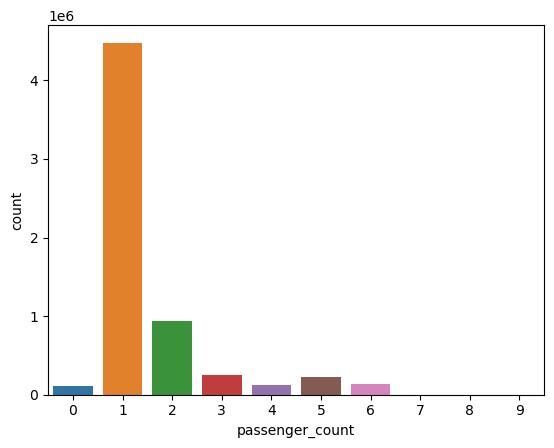

In [23]:
# распределение количества пассажиров
sns.countplot(x='passenger_count', data=dfTipAnalysisPandas)

* Распределение пассажиров позволяет сделать вывод о том, что в подавляющем большинстве случаев поездки совершаются с одним пассажиром.
* Количество поездок более чем с 6 пассажирами - крайне незначительное


In [24]:
print('Количество поездок без пассажиров: ' + str(dfTipAnalysisPandas[dfTipAnalysisPandas['passenger_count'] == 0].passenger_count.count()))
print('Количество поездок c 1 пассажиром: ' + str(dfTipAnalysisPandas[dfTipAnalysisPandas['passenger_count'] == 1].passenger_count.count()))
print('Количество поездок с 2 пассажирами: ' + str(dfTipAnalysisPandas[dfTipAnalysisPandas['passenger_count'] == 2].passenger_count.count()))
print('Количество поездок с 3 пассажирами: ' + str(dfTipAnalysisPandas[dfTipAnalysisPandas['passenger_count'] == 3].passenger_count.count()))
print('Количество поездок с 4 пассажирами: ' + str(dfTipAnalysisPandas[dfTipAnalysisPandas['passenger_count'] == 4].passenger_count.count()))
print('Количество поездок с 5 пассажирами: ' + str(dfTipAnalysisPandas[dfTipAnalysisPandas['passenger_count'] == 5].passenger_count.count()))
print('Количество поездок с 6 пассажирами: ' + str(dfTipAnalysisPandas[dfTipAnalysisPandas['passenger_count'] == 6].passenger_count.count()))
print('Количество поездок с более чем 6 пассажирами: ' + str(dfTipAnalysisPandas[dfTipAnalysisPandas['passenger_count'] > 6].passenger_count.count()))

Количество поездок без пассажиров: 112090
Количество поездок c 1 пассажиром: 4478725
Количество поездок с 2 пассажирами: 936769
Количество поездок с 3 пассажирами: 248045
Количество поездок с 4 пассажирами: 121811
Количество поездок с 5 пассажирами: 224480
Количество поездок с 6 пассажирами: 131582
Количество поездок с более чем 6 пассажирами: 32


* Всего 32 поездки с количеством пассажиров, превышающим 6 человек. Их можно удалить
* Поездки с двумя пассажирами занимают значительную долю, если не учитывать поездки с 1 пассажиром.
* В остальных случаях (3 - 6 пассажиров) порядок количества поездок, примерно, схож.

In [25]:
# Удаление записей поездок с более чем 6 пассажирами 
dfTipAnalysisPandasFiltered = dfTipAnalysisPandas[dfTipAnalysisPandas.passenger_count <= 6]
dfTipAnalysisPandasFiltered.describe()


,passenger_count,trip_distance,tip_amount
count,6.253502e+06,6.253502e+06,6.253502e+06
mean,1.518435e+00,2.881191e+00,2.209432e+00
std,1.154686e+00,3.763497e+00,2.686306e+00
min,0.000000e+00,1.000000e-02,0.000000e+00
25%,1.000000e+00,9.900000e-01,0.000000e+00
50%,1.000000e+00,1.600000e+00,1.960000e+00
75%,2.000000e+00,2.900000e+00,2.860000e+00
max,6.000000e+00,2.628800e+02,1.100000e+03


<Axes: xlabel='passenger_count', ylabel='tip_amount'>

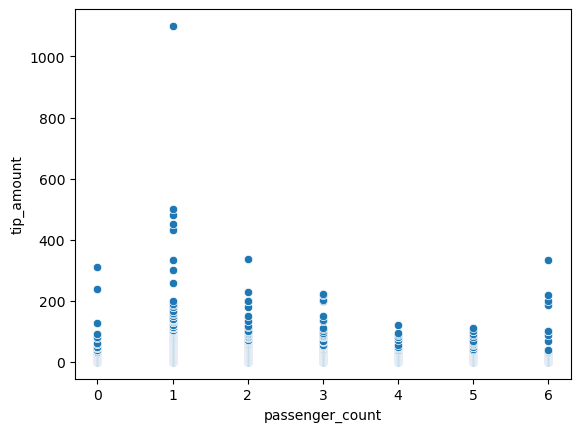

In [26]:
# Оценка сависимости чаевых от количества перевозимых пассажиров
# Построение точечного графика scatterplot с помощью библиотеки seaborn

sns.scatterplot(data=dfTipAnalysisPandasFiltered, x="passenger_count", y="tip_amount")

In [27]:
print('Количество поездок с чаевыми более 10: ' + str(dfTipAnalysisPandas[dfTipAnalysisPandas.tip_amount > 10].tip_amount.count()))
print('Количество поездок с чаевыми более 20: ' + str(dfTipAnalysisPandas[dfTipAnalysisPandas.tip_amount > 20].tip_amount.count()))
print('Количество поездок с чаевыми более 30: ' + str(dfTipAnalysisPandas[dfTipAnalysisPandas.tip_amount > 30].tip_amount.count()))
print('Количество поездок с чаевыми более 50: ' + str(dfTipAnalysisPandas[dfTipAnalysisPandas.tip_amount > 50].tip_amount.count()))
print('Количество поездок с чаевыми более 100: ' + str(dfTipAnalysisPandas[dfTipAnalysisPandas.tip_amount > 100].tip_amount.count()))
print('Количество поездок с чаевыми более 200: ' + str(dfTipAnalysisPandas[dfTipAnalysisPandas.tip_amount > 200].tip_amount.count()))

Количество поездок с чаевыми более 10: 139172
Количество поездок с чаевыми более 20: 4923
Количество поездок с чаевыми более 30: 1375
Количество поездок с чаевыми более 50: 424
Количество поездок с чаевыми более 100: 74
Количество поездок с чаевыми более 200: 17


Очевидно, что записей с чаевыми более 100, крайне мало. Их можно отфильтровать

In [28]:
dfTipAnalysisPandasFiltered = dfTipAnalysisPandasFiltered[dfTipAnalysisPandasFiltered.tip_amount <= 100]
dfTipAnalysisPandasFiltered.describe()

,passenger_count,trip_distance,tip_amount
count,6.253428e+06,6.253428e+06,6.253428e+06
mean,1.518432e+00,2.880993e+00,2.207199e+00
std,1.154683e+00,3.762113e+00,2.562389e+00
min,0.000000e+00,1.000000e-02,0.000000e+00
25%,1.000000e+00,9.900000e-01,0.000000e+00
50%,1.000000e+00,1.600000e+00,1.960000e+00
75%,2.000000e+00,2.900000e+00,2.860000e+00
max,6.000000e+00,2.628800e+02,1.000000e+02


<Axes: xlabel='passenger_count', ylabel='tip_amount'>

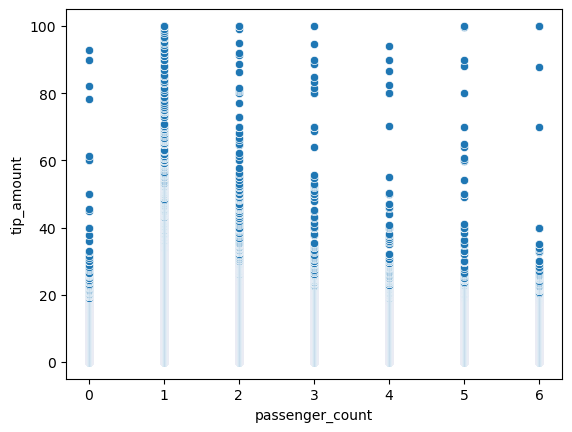

In [29]:
# Построение точечного графика scatterplot с помощью библиотеки seaborn

sns.scatterplot(data=dfTipAnalysisPandasFiltered, x="passenger_count", y="tip_amount")

<Axes: xlabel='passenger_count', ylabel='tip_amount'>

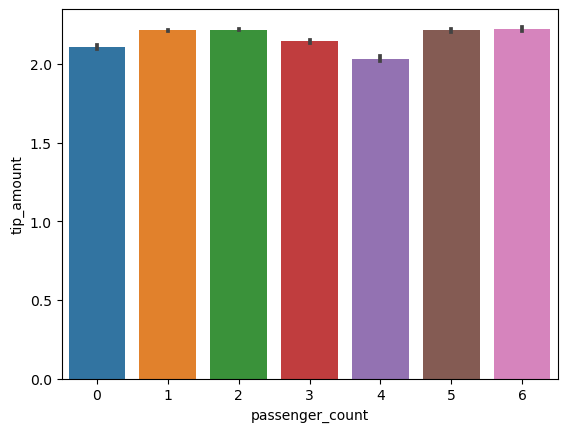

In [30]:
# Постронение диаграммы barplot для оценки соотношения количества пассажииров и размера чаевых без выбросов
sns.barplot(data=dfTipAnalysisPandasFiltered, x="passenger_count", y="tip_amount")


- Диаграммы scatterplot и barplot свидетельствуют о незначительной связи размера чаевых и количества пассажиров такси.
- Также диаграмма scatterplot позволяет судить о наличии выбросов (очень выделяющиеся своим размером чаевые). Для более глубокого анализа их можно отсечь. В данном случае, при оценке зависимости размера чаевых от количества перевозимых пассажиров, эти выбросы не оказали особого влияния.

In [31]:
# Описательная статистика для выборок на основе количества пассажиров
print(dfTipAnalysisPandasFiltered[dfTipAnalysisPandas.passenger_count == 0].describe().round(0))
print(dfTipAnalysisPandasFiltered[dfTipAnalysisPandas.passenger_count == 1].describe().round(0))
print(dfTipAnalysisPandasFiltered[dfTipAnalysisPandas.passenger_count == 2].describe().round(0))
print(dfTipAnalysisPandasFiltered[dfTipAnalysisPandas.passenger_count == 3].describe().round(0))
print(dfTipAnalysisPandasFiltered[dfTipAnalysisPandas.passenger_count == 4].describe().round(0))
print(dfTipAnalysisPandasFiltered[dfTipAnalysisPandas.passenger_count == 5].describe().round(0))
print(dfTipAnalysisPandasFiltered[dfTipAnalysisPandas.passenger_count == 6].describe().round(0))

/tmp/ipykernel_28879/809985082.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(dfTipAnalysisPandasFiltered[dfTipAnalysisPandas.passenger_count == 0].describe().round(0))


       passenger_count  trip_distance  tip_amount
count         112087.0       112087.0    112087.0
mean               0.0            3.0         2.0
std                0.0            4.0         2.0
min                0.0            0.0         0.0
25%                0.0            1.0         0.0
50%                0.0            2.0         2.0
75%                0.0            3.0         3.0
max                0.0           94.0        93.0


/tmp/ipykernel_28879/809985082.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(dfTipAnalysisPandasFiltered[dfTipAnalysisPandas.passenger_count == 1].describe().round(0))


       passenger_count  trip_distance  tip_amount
count        4478679.0      4478679.0   4478679.0
mean               1.0            3.0         2.0
std                0.0            4.0         3.0
min                1.0            0.0         0.0
25%                1.0            1.0         0.0
50%                1.0            2.0         2.0
75%                1.0            3.0         3.0
max                1.0          212.0       100.0


/tmp/ipykernel_28879/809985082.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(dfTipAnalysisPandasFiltered[dfTipAnalysisPandas.passenger_count == 2].describe().round(0))


       passenger_count  trip_distance  tip_amount
count         936759.0       936759.0    936759.0
mean               2.0            3.0         2.0
std                0.0            4.0         3.0
min                2.0            0.0         0.0
25%                2.0            1.0         0.0
50%                2.0            2.0         2.0
75%                2.0            3.0         3.0
max                2.0          242.0       100.0


/tmp/ipykernel_28879/809985082.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(dfTipAnalysisPandasFiltered[dfTipAnalysisPandas.passenger_count == 3].describe().round(0))


       passenger_count  trip_distance  tip_amount
count         248036.0       248036.0    248036.0
mean               3.0            3.0         2.0
std                0.0            4.0         3.0
min                3.0            0.0         0.0
25%                3.0            1.0         0.0
50%                3.0            2.0         2.0
75%                3.0            3.0         3.0
max                3.0          100.0       100.0


/tmp/ipykernel_28879/809985082.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(dfTipAnalysisPandasFiltered[dfTipAnalysisPandas.passenger_count == 4].describe().round(0))


       passenger_count  trip_distance  tip_amount
count         121810.0       121810.0    121810.0
mean               4.0            3.0         2.0
std                0.0            4.0         3.0
min                4.0            0.0         0.0
25%                4.0            1.0         0.0
50%                4.0            2.0         2.0
75%                4.0            3.0         3.0
max                4.0          263.0        94.0


/tmp/ipykernel_28879/809985082.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(dfTipAnalysisPandasFiltered[dfTipAnalysisPandas.passenger_count == 5].describe().round(0))


       passenger_count  trip_distance  tip_amount
count         224479.0       224479.0    224479.0
mean               5.0            3.0         2.0
std                0.0            4.0         3.0
min                5.0            0.0         0.0
25%                5.0            1.0         0.0
50%                5.0            2.0         2.0
75%                5.0            3.0         3.0
max                5.0           74.0       100.0


/tmp/ipykernel_28879/809985082.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(dfTipAnalysisPandasFiltered[dfTipAnalysisPandas.passenger_count == 6].describe().round(0))


       passenger_count  trip_distance  tip_amount
count         131578.0       131578.0    131578.0
mean               6.0            3.0         2.0
std                0.0            4.0         3.0
min                6.0            0.0         0.0
25%                6.0            1.0         0.0
50%                6.0            2.0         2.0
75%                6.0            3.0         3.0
max                6.0           63.0       100.0


Статистические параметры, описывающие данные, подтверждают вывод о незначительном влиянии количества пассажиров на размер чаевых.

Вывод: размер чаевых незначительно зависит от количества пассажиров

# Анализ соотношения размера чаевых и пройденного расстояния

In [33]:
# Оценка распределения дистанции поездок 
print('Количество поездок с на расстояние более 50: ' + str(dfTipAnalysisPandas[dfTipAnalysisPandas.trip_distance > 50].trip_distance.count()))
print('Количество поездок с на расстояние более 40: ' + str(dfTipAnalysisPandas[dfTipAnalysisPandas.trip_distance > 40].trip_distance.count()))
print('Количество поездок с на расстояние более 30: ' + str(dfTipAnalysisPandas[dfTipAnalysisPandas.trip_distance > 30].trip_distance.count()))
print('Количество поездок с на расстояние более 20: ' + str(dfTipAnalysisPandas[dfTipAnalysisPandas.trip_distance > 20].trip_distance.count()))
print('Количество поездок с на расстояние более 10: ' + str(dfTipAnalysisPandas[dfTipAnalysisPandas.trip_distance > 10].trip_distance.count()))

Количество поездок с на расстояние более 50: 364
Количество поездок с на расстояние более 40: 875
Количество поездок с на расстояние более 30: 3195
Количество поездок с на расстояние более 20: 40845
Количество поездок с на расстояние более 10: 341512


- Количество попоездок на расстояние более 40 км является незначительным и может быть отфильтровано из датафрейма

In [34]:
# Отфильтровывание выбросов (значения расстояния более 40)
dfTipAnalysisPandasFiltered = dfTipAnalysisPandasFiltered[dfTipAnalysisPandasFiltered.trip_distance <= 40]

In [35]:
# Сортировка данных по дистанции, размеру чаевых, количеству перевезенных пассажиров
dfTipAnalysisPandasFilteredSortByDist = dfTipAnalysisPandasFiltered.sort_values(by=['trip_distance', 'tip_amount', 'passenger_count'], ascending=[True, True, True])

In [36]:
# Колонка с диапазонами пройденного расстояния
dfTipAnalysisPandasFilteredSortByDist['bins_dist'] = pd.cut(dfTipAnalysisPandasFilteredSortByDist['trip_distance'], bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20])


/opt/python/anaconda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/python/anaconda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='trip_distance', ylabel='tip_amount'>

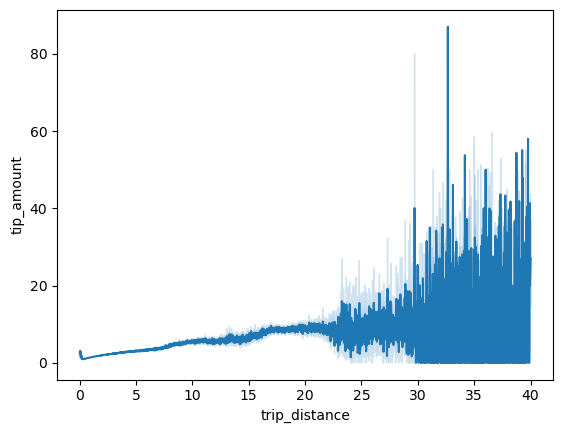

In [38]:
# График зависимости размера чаевых от пройденного расстояния
sns.lineplot(data=dfTipAnalysisPandasFilteredSortByDist, x="trip_distance", y="tip_amount")

- На основе построенного графика зависимости размера чаевых от пройденного расстояния можно сделать вывод о том, что с увеличением пройденного расстояния, растёт и размер чаевых.


* Построение тепловой карты для отображения влияния пройденного расстояния и количества пассажиров на размер чаевых

In [39]:
pivot = dfTipAnalysisPandasFilteredSortByDist.pivot_table(
    index=["bins_dist"],
    columns=["passenger_count"],
    values="tip_amount",
    aggfunc='median')
pivot

passenger_count,0,1,2,3,4,5,6
bins_dist,,,,,,,
"(0, 1]",1.40,1.46,1.46,1.45,1.240,1.46,1.46
"(1, 2]",2.00,2.00,2.00,2.00,1.950,2.00,2.00
"(2, 3]",2.50,2.56,2.56,2.55,2.370,2.56,2.56
"(3, 4]",3.00,3.06,3.06,3.00,2.740,3.16,3.06
"(4, 5]",3.55,3.57,3.66,3.56,3.000,3.66,3.56
"(5, 6]",4.00,4.00,4.00,3.66,3.000,4.06,3.96
"(6, 7]",4.00,4.36,4.26,4.00,3.235,4.32,4.10
"(7, 8]",4.94,5.00,5.00,4.60,4.955,5.00,5.00
"(8, 9]",5.95,5.86,5.76,5.76,5.055,5.80,5.86


Text(0.5, 1.0, 'Зависимость размера чаевых от пройденного расстояния и количества пассажиров')

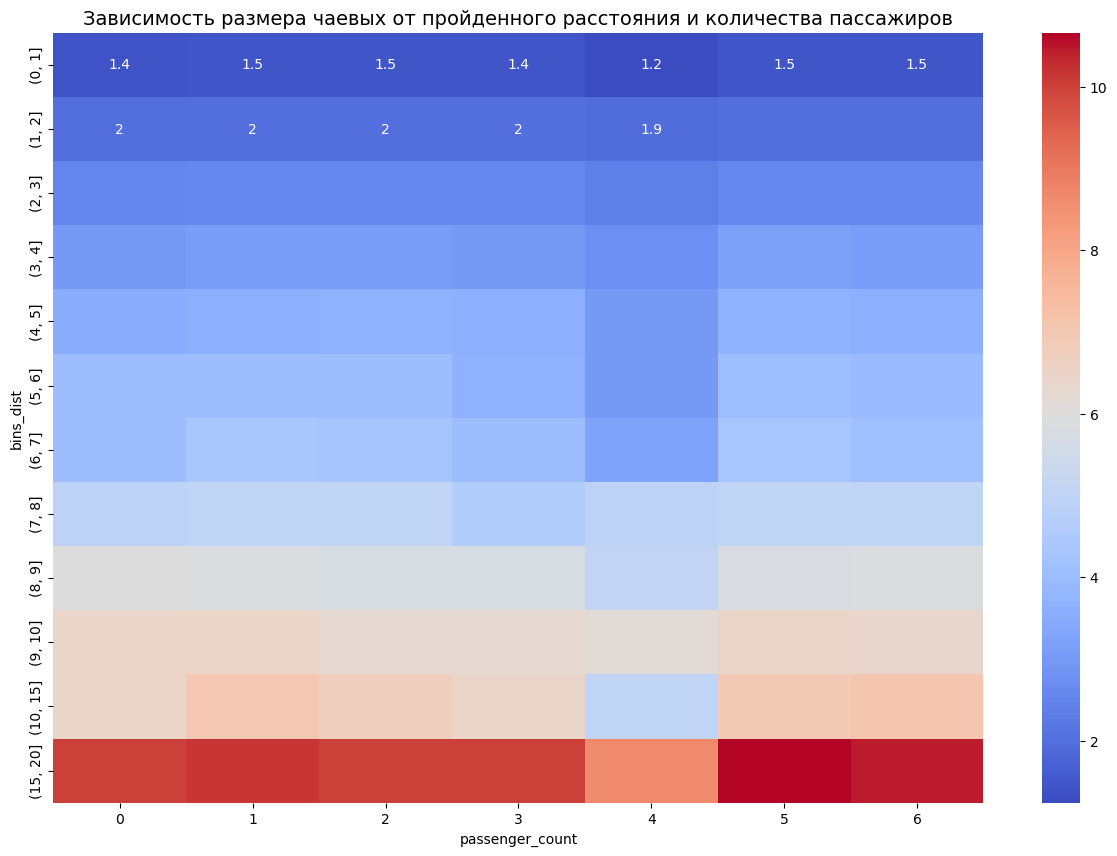

In [42]:
fig, axes = plt.subplots(figsize=(15, 10))
sns.heatmap(data=pivot, cmap="coolwarm", annot=True)\
    .set_title('Зависимость размера чаевых от пройденного расстояния и количества пассажиров', fontsize=14)

На основании тепловой карты очевидно, что размер чаевых прямопропорционален пройденному расстоянию. На расстоянии 15 - 20 чаевые - наибольшие, это практически не зависит от количества пассажиров. Меньше всего чаевых оставляют группы пассажиров в количестве 4 человек. Больше всего чаевых оставляют одинокие пассажиры и группы по 5-6 человек.